In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from elm2 import ELMClassifier, ELMRegressor, GenELMClassifier, GenELMRegressor
from random_layer import RandomLayer, MLPRandomLayer, RBFRandomLayer, GRBFRandomLayer

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import pipeline
from sklearn.linear_model import LinearRegression

import xgboost as xgb
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.utils import shuffle
from scipy import stats
from sklearn import preprocessing

import datetime as dt
import math as mt

from time import time

In [2]:
def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = dataframe_y_true[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    pred = dataframe_y_pred[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = dataframe_y_true[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    pred = dataframe_y_pred[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = dataframe_y_true[~dataframe_y_true['TV'].isna()]['TV']
    pred = dataframe_y_pred[~dataframe_y_true['TV'].isna()]['TV']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = dataframe_y_true[~dataframe_y_true['kettle'].isna()]['kettle']
    pred = dataframe_y_pred[~dataframe_y_true['kettle'].isna()]['kettle']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score

In [16]:
def rmse(col_true, col_pred):
    return mt.sqrt(sum((col_pred - col_true)**2)/len(col_true))

### Load Data and Inspect

In [3]:
X_train = pd.read_csv("X_train.csv")
X_train = X_train[X_train.columns[:-1]]
X_train.head(5)

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure
0,2013-03-17T00:01:00.0,550.4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-03-17T00:02:00.0,548.6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-03-17T00:03:00.0,549.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-03-17T00:04:00.0,549.3667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-03-17T00:05:00.0,548.8909,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
y_train = pd.read_csv("y_train.csv")
y_train.head(5)

,time_step,washing_machine,fridge_freezer,TV,kettle
0,2013-03-17T00:01:00.0,0.0,79.2000,7.0,0.0
1,2013-03-17T00:02:00.0,0.0,78.0000,7.0,0.0
2,2013-03-17T00:03:00.0,0.0,76.9000,7.0,0.0
3,2013-03-17T00:04:00.0,0.0,76.1111,7.0,0.0
4,2013-03-17T00:05:00.0,0.0,75.2727,7.0,0.0


In [5]:
X_test = pd.read_csv("X_test.csv")
X_test = X_test[X_test.columns[:-1]]
X_test.head(5)

,time_step,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure
0,2014-01-01T00:00:00.0,312.2222,30.0,8.4,86.0,8.4,5.6,17.0,1016.6
1,2014-01-01T00:01:00.0,318.8750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-01T00:02:00.0,314.3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-01T00:03:00.0,311.4444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-01T00:04:00.0,310.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
X_train = X_train.sort_values(by="time_step")
y_train = y_train.sort_values(by="time_step")

### Data Transformation Function

1. Missing value imputaton;
2. Derive time features (date, hour, minute, dayofweek, isweekend, hour_sin, hour_cos, minute_sin, minute_cos, time_sin, time_cos);
3. Hourly/Semi-hourly aggregations: mean, std, max, min;
4. PCA of weather features;
5. Windows with margin (is_kettle, is_washing, kettle_current, washing_current);
6. Consumption shifting (5 mins)

In [7]:
## Only feasible for transforming X (not y)
## fe = FeatureExtractor()
## X_DF = fe.transform(X_test, leave_null)
## Pass leave_null = True for train data,
## leave_null = False for test data.

class FeatureExtractor(object):
    def __init__(self):
        self.X_transformed = None

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df, limit=5, leave_null=True):
        
        X_transformed = X_df.copy()
        
        # Missing Value Imputation
        sample1 = X_transformed.interpolate(method='linear')
        sample1 = sample1.interpolate(method='linear', limit_direction='both')
        sample1['consumption'] = X_transformed['consumption']
        X_transformed = sample1.copy()
        
        X_transformed = X_transformed.interpolate(method='nearest', limit_direction='forward', limit=limit)
        
        # Derive Time Features
        X_transformed['date'] = X_transformed['time_step'].str[:10]
        X_transformed['hour'] = X_transformed['time_step'].str[11:13].astype('int')
        X_transformed['minute'] = X_transformed['time_step'].str[14:16].astype('int')

        X_transformed['date'] = pd.to_datetime(X_transformed['date'], infer_datetime_format=True)

        X_transformed['dayofweek'] = X_transformed['date'].dt.dayofweek
        
        isweekend = []
        for day in list(X_transformed['dayofweek']):
            if day in [5,6]:
                isweekend.append(1)
            else:
                isweekend.append(0)
        X_transformed['isweekend'] = isweekend
        
        X_transformed = pd.concat([X_transformed, pd.get_dummies(X_transformed['dayofweek'], prefix='day'),
                           pd.get_dummies(X_transformed['hour'], prefix='hour')], axis=1)
        
        X_transformed['hour_sin'] = np.sin((X_transformed['hour'] + 1) * 360. / 24. * np.pi / 180. )
        X_transformed['hour_cos'] = np.cos((X_transformed['hour'] + 1) * 360. / 24. * np.pi / 180. )

        X_transformed['minute_sin'] = np.sin((X_transformed['minute'] + 1) * 360. / 60. * np.pi / 180. )
        X_transformed['minute_cos'] = np.cos((X_transformed['minute'] + 1) * 360. / 60. * np.pi / 180. )
        
        X_transformed['time'] = (X_transformed['hour'].astype('int') % 12) * 60 + X_transformed['minute'].astype('int')
        X_transformed['time_sin'] = np.sin((X_transformed['time'] + 1) * 360. / 720. * np.pi / 180. )
        X_transformed['time_cos'] = np.cos((X_transformed['time'] + 1) * 360. / 720. * np.pi / 180. )
        
        # Computing Hourly Aggregations
        X_transformed['hour_step'] = X_transformed['time_step'].str[:13]
        consumption_part_hour = X_transformed[['hour_step', 'consumption']].dropna()
        hourly_avg = consumption_part_hour.groupby(by='hour_step').mean().reset_index()
        hourly_avg.columns = ['hour_step', 'hourly_avg']
        hourly_max = consumption_part_hour.groupby(by='hour_step').max().reset_index()
        hourly_max.columns = ['hour_step', 'hourly_max']
        hourly_min = consumption_part_hour.groupby(by='hour_step').min().reset_index()
        hourly_min.columns = ['hour_step', 'hourly_min']
        hourly_std = consumption_part_hour.groupby(by='hour_step').std().reset_index()
        hourly_std.columns = ['hour_step', 'hourly_std']
        
        hourly_agg = hourly_avg.me
        
        
        rge(hourly_max,
                 how="left",
                 left_on=['hour_step'],
                 right_on=['hour_step'],
                 sort=False
                ).merge(hourly_min,
                 how="left",
                 left_on=['hour_step'],
                 right_on=['hour_step'],
                 sort=False
                ).merge(hourly_std,
                 how="left",
                 left_on=['hour_step'],
                 right_on=['hour_step'],
                 sort=False)
        
        X_transformed = pd.merge(X_transformed, hourly_agg,
                                 how="left",
                                 left_on=['hour_step'],
                                 right_on=['hour_step'],
                                 sort=False
                                )
        X_transformed['hourly_diff'] = X_transformed['hourly_max'] - X_transformed['hourly_min']
        
        # Computing Half-Hourly Aggregations
        X_transformed['half_hour_step'] = pd.to_datetime(X_transformed['time_step'].str[:14] + 
                                           ((X_transformed['minute'] // 30) * 30).astype(str), 
                                           format='%Y-%m-%dT%H:%M')
                                           
        consumption_half_hour = X_transformed[['half_hour_step', 'consumption']].dropna()

        hourly30_avg = consumption_half_hour.groupby(by='half_hour_step').mean().reset_index()
        hourly30_avg.columns = ['half_hour_step', 'half_hourly_avg']
        hourly30_max = consumption_half_hour.groupby(by='half_hour_step').max().reset_index()
        hourly30_max.columns = ['half_hour_step', 'half_hourly_max']
        hourly30_min = consumption_half_hour.groupby(by='half_hour_step').min().reset_index()
        hourly30_min.columns = ['half_hour_step', 'half_hourly_min']
        hourly30_std = consumption_half_hour.groupby(by='half_hour_step').std().reset_index()
        hourly30_std.columns = ['half_hour_step', 'half_hourly_std']


        hourly30_agg = hourly30_avg.merge(hourly30_max,
                 how="left",
                 left_on=['half_hour_step'],
                 right_on=['half_hour_step'],
                 sort=False
                ).merge(hourly30_min,
                 how="left",
                 left_on=['half_hour_step'],
                 right_on=['half_hour_step'],
                 sort=False
                ).merge(hourly30_std,
                 how="left",
                 left_on=['half_hour_step'],
                 right_on=['half_hour_step'],
                 sort=False)
        
        X_transformed = pd.merge(X_transformed, hourly30_agg,
                                 how="left",
                                 left_on=['half_hour_step'],
                                 right_on=['half_hour_step'],
                                 sort=False
                                )
        X_transformed['half_hourly_diff'] = X_transformed['half_hourly_max'] - X_transformed['half_hourly_min']
        
        # PCA of Weather Features
        PCA_features = ['visibility', 'temperature', 'humidity', 'humidex', 'windchill', 'wind', 'pressure']
        PCA_data = X_transformed[PCA_features]

        pca = PCA(n_components=3)
        pca3_feature = pca.fit_transform(PCA_data)
        
        X_transformed['WeatherPCA1'] = pca3_feature[:,0]
        X_transformed['WeatherPCA2'] = pca3_feature[:,1]
        X_transformed['WeatherPCA3'] = pca3_feature[:,2]
        
        # Windows with margin
        def window_diff(series, start_pos, size, margin):
            begin = time()
            starting_avg = np.mean(series[start_pos:start_pos+margin])
            ending_avg = np.mean(series[start_pos+size-margin:start_pos+size])
            end = time()
            #print("CalcDiff Time: %.5f s" %(end-begin))
            return ending_avg - starting_avg

        def window_state(series, start_pos, size, margin, threshold):
            diff = window_diff(series, start_pos, size, margin)
            if diff > threshold:
                return 1
            elif diff < -threshold:
                return -1
            else:
                return 0

        def window_update(series, size, margin, threshold):
            begin1 = time()
            states = pd.Series(len(series)*[0])
            len_series = len(series)
            for i in range(len_series-size):
                #if i % 10000 == 0:
                    #print(i)
                begin = time()
                states[i] = window_state(series, i, size, margin, threshold)
                end = time()
                #print("Update Time: %.5f s" %(end-begin))
            states[len_series-size:] = window_state(series, len_series-size, size, margin, threshold)
            end1 = time()
            #print("Total Time: %.5f s" %(end1-begin1))
            return states

        #######
        def OnOff_update(window_series, size):
            begin1 = time()
            len_series = len(window_series)
            states = pd.Series(len_series*[0])
            i = 0
            while i <= len_series - size:
                #if i % 20000 == 0:
                    #print(i)
                begin = time()
                current_state = window_series[i]
                next_state = window_series[i+1]
                if current_state == 1 and next_state == 0:
                    states[i:i+size] = 1
                    i = i + size
                else:
                    i = i + 1
                end = time()
                #print("Update Time: %.5f s" %(end-begin))
            states[i:] = window_series[i]
            end1 = time()
            #print("Total Time: %.5f s" %(end1-begin1))
            return states
        
        X_transformed['is_kettle_2500'] = window_update(X_transformed['consumption'], 3, 1, 2500)
        X_transformed['is_kettle_2700'] = window_update(X_transformed['consumption'], 3, 1, 2700)
        X_transformed['is_kettle_2700_5'] = window_update(X_transformed['consumption'], 5, 1, 2700)
        X_transformed['is_washing_1800_5'] = window_update(X_transformed['consumption'], 100, 5, 1800)
        X_transformed['is_washing_2000_10'] = window_update(X_transformed['consumption'], 100, 10, 2000)
        X_transformed['is_washing_2000_5'] = window_update(X_transformed['consumption'], 100, 5, 2000)
        
        X_transformed['kettle_current1'] = OnOff_update(X_transformed['is_kettle_2500'], 3)
        X_transformed['kettle_current2'] = OnOff_update(X_transformed['is_kettle_2700'], 3)
        X_transformed['kettle_current3'] = OnOff_update(X_transformed['is_kettle_2700_5'], 5)
        X_transformed['washing_current1'] = OnOff_update(X_transformed['is_washing_1800_5'], 100)
        X_transformed['washing_current2'] = OnOff_update(X_transformed['is_washing_2000_10'], 100)
        X_transformed['washing_current3'] = OnOff_update(X_transformed['is_washing_2000_5'], 100)
        
        # Consumption Shifting
        X_transformed['consumption_last1min'] = X_transformed['consumption'].shift(1)
        X_transformed['consumption_last2min'] = X_transformed['consumption'].shift(2)
        X_transformed['consumption_last3min'] = X_transformed['consumption'].shift(3)
        X_transformed['consumption_last4min'] = X_transformed['consumption'].shift(4)
        X_transformed['consumption_last5min'] = X_transformed['consumption'].shift(5)
    
        # Null Value Imputation
        if leave_null == False:
            X_transformed = X_transformed.fillna(0)
        
        return X_transformed
    
    def transform_cols(self, X_df):
        return self.X_transformed.columns
    
    def getDF(self):
        return self.X_transformed

In [8]:
### Transform X_train
fe = FeatureExtractor()
X_train = fe.transform(X_train, leave_null=True)

### Transform X_test
X_test = fe.transform(X_test, leave_null=False)

In [9]:
y_train = y_train.interpolate(method='nearest', limit_direction='forward', limit=5)

In [11]:
X_train.to_csv("X_train_trans.csv", index=False)
X_test.to_csv("X_test_trans.csv", index=False)
y_train.to_csv("y_train_trans.csv", index=False)

### Data Integration

In [12]:
train = pd.merge(X_train, y_train,
                 how="left",
                 left_on=['time_step'],
                 right_on=['time_step'],
                 sort=False
                )

### Visualization

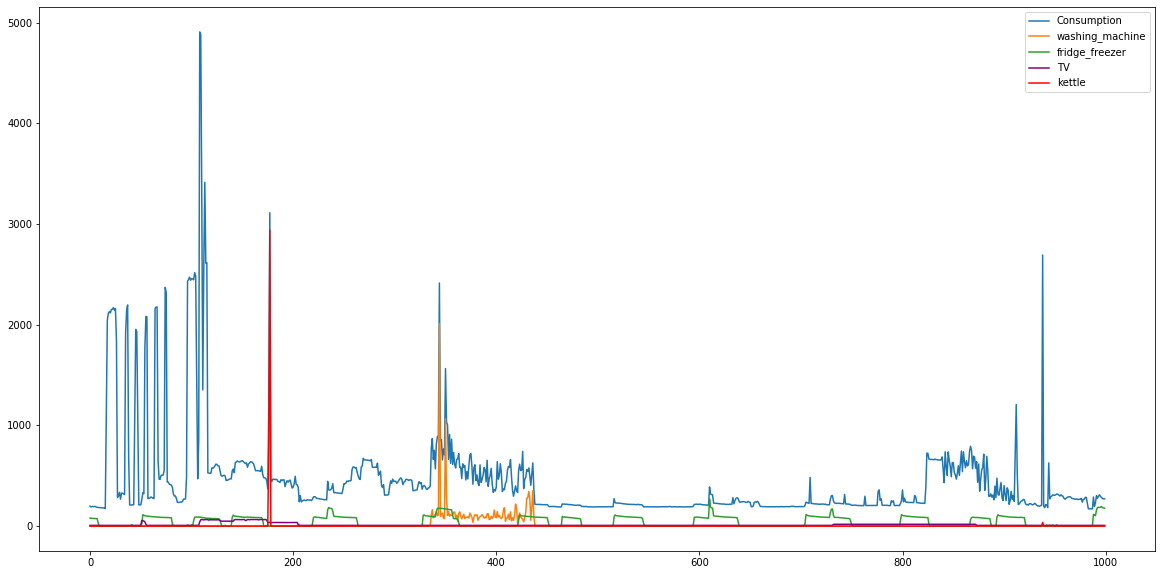

In [16]:
fig = plt.figure(figsize=(20,10))

size = 1000
start = 2400

plot_sample = train.iloc[start:start+size,:]
plt.plot(np.arange(0,size,1), plot_sample['consumption'], label='Consumption')
plt.plot(np.arange(0,size,1), plot_sample['washing_machine'], label='washing_machine')
plt.plot(np.arange(0,size,1), plot_sample['fridge_freezer'], label='fridge_freezer')
plt.plot(np.arange(0,size,1), plot_sample['TV'], label='TV', color="purple")
plt.plot(np.arange(0,size,1), plot_sample['kettle'], label='kettle', color="red")

plt.legend()

plt.show()

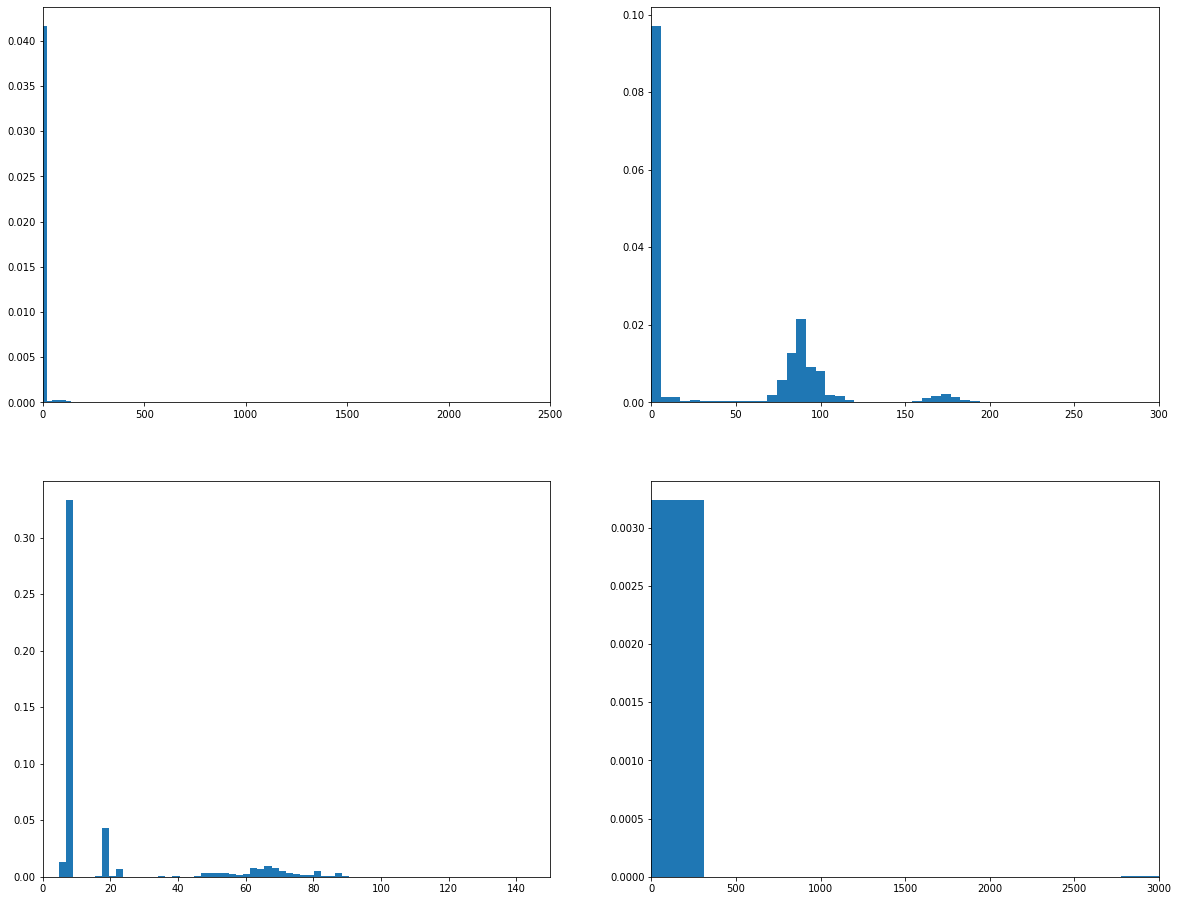

In [17]:
plt.figure(1,figsize = (20,16))

size = 50000
plot_sample = train.iloc[:size,:]

plt.subplot(221)
plt.hist(plot_sample.washing_machine, bins=100, density=True)
plt.xlim(0,2500)

plt.subplot(222)
plt.hist(plot_sample.fridge_freezer, bins=50, density=True)
plt.xlim(0,300)

plt.subplot(223)
plt.hist(plot_sample.TV, bins=50, density=True)
plt.xlim(0,150)

plt.subplot(224)
plt.hist(plot_sample.kettle, bins=10, density=True)
plt.xlim(0,3000)

plt.show()

### Invalid Data Filtering

In [13]:
train_notnull = train[train['consumption'].notna()]
train_notnull = train_notnull[train_notnull['consumption_last5min'].notna()]
train_notnull = train_notnull.fillna(0)

In [14]:
train_notnull.isna().sum()

time_step               0
consumption             0
visibility              0
temperature             0
humidity                0
humidex                 0
windchill               0
wind                    0
pressure                0
date                    0
hour                    0
minute                  0
dayofweek               0
isweekend               0
day_0                   0
day_1                   0
day_2                   0
day_3                   0
day_4                   0
day_5                   0
day_6                   0
hour_0                  0
hour_1                  0
hour_2                  0
hour_3                  0
hour_4                  0
hour_5                  0
hour_6                  0
hour_7                  0
hour_8                  0
                       ..
half_hour_step          0
half_hourly_avg         0
half_hourly_max         0
half_hourly_min         0
half_hourly_std         0
half_hourly_diff        0
WeatherPCA1             0
WeatherPCA2 

### Feature Set Definition

In [15]:
train_notnull.columns

Index(['time_step', 'consumption', 'visibility', 'temperature', 'humidity',
       'humidex', 'windchill', 'wind', 'pressure', 'date', 'hour', 'minute',
       'dayofweek', 'isweekend', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'time', 'time_sin',
       'time_cos', 'hour_step', 'hourly_avg', 'hourly_max', 'hourly_min',
       'hourly_std', 'hourly_diff', 'half_hour_step', 'half_hourly_avg',
       'half_hourly_max', 'half_hourly_min', 'half_hourly_std',
       'half_hourly_diff', 'WeatherPCA1', 'WeatherPCA2', 'WeatherPCA3',
       'is_kettle_2500', 'is_kettle_2700', 'is_kettle_2700_5',
       'is_washing_1800_5', 'is_washing_2000

In [219]:
X_vars = ['consumption', 'visibility', 'temperature', 'humidity','humidex',
                   'windchill', 'wind', 'pressure']
y_vars = ['washing_machine','fridge_freezer','TV','kettle']
X_vars_base = ['consumption']
X_vars_3mins = ['consumption_last1min', 'consumption_last2min', 'consumption_last3min']
X_vars_5mins = ['consumption_last1min', 'consumption_last2min', 'consumption_last3min',
               'consumption_last4min', 'consumption_last5min']
X_vars_day = ['isweekend', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
X_vars_hour1 = ['hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23']
X_vars_hour2 = ['hour_sin', 'hour_cos']
X_vars_minute = ['minute_sin', 'minute_cos']
X_vars_time = ['time_sin', 'time_cos']
X_vars_hourly = ['hourly_avg', 'hourly_std', 'hourly_max', 'hourly_min']
X_vars_half_hourly = ['half_hourly_avg', 'half_hourly_std', 'half_hourly_max', 'half_hourly_min']
X_vars_weather1 = ['visibility', 'temperature', 'humidity',
                   'humidex', 'windchill', 'wind', 'pressure']
X_vars_weather2 = ['WeatherPCA1', 'WeatherPCA2', 'WeatherPCA3']
X_vars_window1 = ['is_kettle_2500', 'is_washing_1800_5', 'kettle_current1', 'washing_current1']
X_vars_window2 = ['is_kettle_2700', 'is_washing_2000_10', 'kettle_current2', 'washing_current2']
X_vars_window3 = ['is_kettle_2700_5', 'is_washing_2000_5', 'kettle_current3', 'washing_current3']

In [18]:
train_notnull[['time_step']+X_vars_base+X_vars_hourly].head(5)

,time_step,consumption,hourly_avg,hourly_std,hourly_max,hourly_min
5,2013-03-17T00:06:00.0,549.6333,564.871692,26.010367,668.0111,533.9
6,2013-03-17T00:07:00.0,548.4714,564.871692,26.010367,668.0111,533.9
7,2013-03-17T00:08:00.0,550.2159,564.871692,26.010367,668.0111,533.9
8,2013-03-17T00:09:00.0,549.4444,564.871692,26.010367,668.0111,533.9
9,2013-03-17T00:10:00.0,548.4750,564.871692,26.010367,668.0111,533.9


## Model Experimentation

0 - washing_machine; 1 - fridge_freezer; 2 - TV; 3 - kettle;

### I. Linear Model

`sklearn.LinearRegression()`

In [16]:
train_notnull.columns

Index(['time_step', 'consumption', 'visibility', 'temperature', 'humidity',
       'humidex', 'windchill', 'wind', 'pressure', 'date', 'hour', 'minute',
       'dayofweek', 'isweekend', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'time', 'time_sin',
       'time_cos', 'hour_step', 'hourly_avg', 'hourly_max', 'hourly_min',
       'hourly_std', 'hourly_diff', 'half_hour_step', 'half_hourly_avg',
       'half_hourly_max', 'half_hourly_min', 'half_hourly_std',
       'half_hourly_diff', 'WeatherPCA1', 'WeatherPCA2', 'WeatherPCA3',
       'is_kettle_2500', 'is_kettle_2700', 'is_kettle_2700_5',
       'is_washing_1800_5', 'is_washing_2000

In [ ]:
#train_notnull['time'] = train_notnull['hour'].astype('int') * 60 + train_notnull['minute'].astype('int')
#train_notnull['time_sin'] = np.sin((train_notnull['time'] + 1) * 360. / 1440. * np.pi / 180. )
#train_notnull['time_cos'] = np.cos((train_notnull['time'] + 1) * 360. / 1440. * np.pi / 180. )

In [147]:
train_notnull['time'] = (train_notnull['hour'].astype('int') % 12) * 60 + train_notnull['minute'].astype('int')
train_notnull['time_sin'] = np.sin((train_notnull['time'] + 1) * 360. / 720. * np.pi / 180. )
train_notnull['time_cos'] = np.cos((train_notnull['time'] + 1) * 360. / 720. * np.pi / 180. )

In [134]:
X_vars_set = X_vars_base + X_vars_day + X_vars_time + X_vars_half_hourly
#X_vars_set = X_vars_base+X_vars_3mins+X_vars_day+X_vars_hour2+X_vars_minute+X_vars_weather2+X_vars_window3
#X_vars_set = X_vars_base+X_vars_3mins+X_vars_day+X_vars_hour2+X_vars_weather2+X_vars_window3

In [135]:
X = train_notnull[['time_step']+X_vars_set]
y = train_notnull[y_vars]

In [136]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
print('Train size: {train}, Validation size: {test}'.format(train=x_train.shape[0], test=x_valid.shape[0]))

Train size: 367974, Validation size: 40886


In [137]:
x_train.columns

Index(['time_step', 'consumption', 'isweekend', 'day_0', 'day_1', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'time_sin', 'time_cos',
       'hourly_avg', 'hourly_std', 'hourly_diff'],
      dtype='object')

In [112]:
# May lead to very bad results
#scaler = StandardScaler()
#x_scaled = scaler.fit_transform(x_train[x_train.columns[1:]])
#y_scaled = scaler.fit_transform(y_train)

In [138]:
x_scaled = x_train[x_train.columns[1:]].to_numpy()
y_scaled = y_train.to_numpy()

In [139]:
len(y_scaled[:,0])

367974

In [140]:
# it is better to run this step first
y_pred = x_valid[['time_step']]

In [141]:
reg1 = LinearRegression().fit(x_scaled, y_scaled[:,0])
y_pred['washing_machine'] = reg1.predict(x_valid[X_vars_set])

reg2 = LinearRegression().fit(x_scaled, y_scaled[:,1])
y_pred['fridge_freezer'] = reg2.predict(x_valid[X_vars_set])

reg3 = LinearRegression().fit(x_scaled, y_scaled[:,2])
y_pred['TV'] = reg3.predict(x_valid[X_vars_set])

reg4 = LinearRegression().fit(x_scaled, y_scaled[:,3])
y_pred['kettle'] = reg4.predict(x_valid[X_vars_set])

In [142]:
metric_nilm(y_valid, y_pred)

48.82322866785768

### II. ELM / Hierarchical-ELMs (H-ELMs)

    Parameters
    ----------
    `n_hidden` : int, optional (default=20)
        Number of units to generate in the SimpleRandomLayer
    `alpha` : float, optional (default=0.5)
        Mixing coefficient for distance and dot product input activations:
        activation = alpha*mlp_activation + (1-alpha)*rbf_width*rbf_activation
    `rbf_width` : float, optional (default=1.0)
        multiplier on rbf_activation
    `activation_func` : {callable, string} optional (default='tanh')
        Function used to transform input activation
        It must be one of 'tanh', 'sine', 'tribas', 'inv_tribase', 'sigmoid',
        'hardlim', 'softlim', 'gaussian', 'multiquadric', 'inv_multiquadric' or
        a callable.  If none is given, 'tanh' will be used. If a callable
        is given, it will be used to compute the hidden unit activations.
    `activation_args` : dictionary, optional (default=None)
        Supplies keyword arguments for a callable activation_func
    `user_components`: dictionary, optional (default=None)
        dictionary containing values for components that woud otherwise be
        randomly generated.  Valid key/value pairs are as follows:
           'radii'  : array-like of shape [n_hidden]
           'centers': array-like of shape [n_hidden, n_features]
           'biases' : array-like of shape [n_hidden]
           'weights': array-like of shape [n_hidden, n_features]
    `regressor`    : regressor instance, optional (default=None)
        If provided, this object is used to perform the regression from hidden
        unit activations to the outputs and subsequent predictions.  If not
        present, an ordinary linear least squares fit is performed
    `random_state`  : int, RandomState instance or None (default=None)
        Control the pseudo random number generator used to generate the
        hidden unit weights at fit time.

In [22]:
X = train_notnull
y = train_notnull[y_vars]

In [23]:
X_train, x_valid, Y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
print('Train size: {train}, Validation size: {test}'.format(train=X_train.shape[0], test=y_valid.shape[0]))

Train size: 367974, Validation size: 40886


#### Test results for different feature sets:
n_hidden = 256, activation_func='multiquadric', random_state=24 (the result is largely dependent on the random state)
1. X_vars_set = X_vars_base + X_vars_day + X_vars_time: 102.3
2. X_vars_set = X_vars_base + X_vars_day + X_vars_time + X_vars_hourly: 40.8
3. X_vars_set = X_vars_base + X_vars_day + X_vars_time + X_vars_half_hourly: 41.6
4. X_vars_set = X_vars_base + X_vars_day + X_vars_time + X_vars_hourly + X_vars_window3: 41.12
5. X_vars_set = X_vars_base + X_vars_day + X_vars_time + X_vars_hourly + X_vars_window2: 41.10
6. X_vars_set = X_vars_base + X_vars_day + X_vars_time + X_vars_hourly + X_vars_window1: 41.0
7. X_vars_set = X_vars_base + X_vars_day + X_vars_time + X_vars_window1: 57.2
8. X_vars_set = X_vars_base + X_vars_day + X_vars_time + X_vars_window2: 60.1
9. X_vars_set = X_vars_base + X_vars_day + X_vars_hour1 + X_vars_time + X_vars_hourly: 40.5

In [109]:
X_vars_set = X_vars_base + X_vars_day + X_vars_hour1 + X_vars_time + X_vars_hourly
#X_vars_set = X_vars_base+X_vars_3mins+X_vars_day+X_vars_hour2+X_vars_weather2+X_vars_window3
#X_vars_set = X_vars_base+X_vars_3mins+X_vars_day+X_vars_hour2+X_vars_minute+X_vars_weather2+X_vars_window3

In [110]:
x_train = X_train[['time_step']+X_vars_set]
y_train = Y_train[y_vars]

In [85]:
#X = train_notnull[['time_step']+X_vars_set]
#y = train_notnull[y_vars]

In [111]:
x_train.columns

Index(['time_step', 'consumption', 'isweekend', 'day_0', 'day_1', 'day_2',
       'day_3', 'day_4', 'day_5', 'day_6', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'time_sin', 'time_cos', 'hourly_avg',
       'hourly_std', 'hourly_max', 'hourly_min'],
      dtype='object')

In [ ]:
#scaler = StandardScaler()
#x_scaled = scaler.fit_transform(x_train[x_train.columns[1:]])
#y_scaled = scaler.fit_transform(y_train)

In [112]:
x_scaled = x_train[x_train.columns[1:]].to_numpy()
y_scaled = y_train.to_numpy()

In [113]:
# it is better to run this step first
y_pred = x_valid[['time_step']]

In [114]:
elmr = ELMRegressor(random_state=24, n_hidden=256, activation_func='multiquadric', alpha=0.7)

elmr1 = elmr.fit(x_scaled, y_scaled[:,0])
y_pred['washing_machine'] = elmr1.predict(x_valid[X_vars_set])
print("Finished First.\n")

elmr2 = elmr.fit(x_scaled, y_scaled[:,1])
y_pred['fridge_freezer'] = elmr2.predict(x_valid[X_vars_set])
print("Finished Second.\n")

elmr3 = elmr.fit(x_scaled, y_scaled[:,2])
y_pred['TV'] = elmr3.predict(x_valid[X_vars_set])
print("Finished Third.\n")

elmr4 = elmr.fit(x_scaled, y_scaled[:,3])
y_pred['kettle'] = elmr4.predict(x_valid[X_vars_set])
print("Finished Fourth.\n")

Finished First.

Finished Second.

Finished Third.

Finished Fourth.



In [115]:
metric_nilm(y_valid, y_pred)

40.45672602247868

In [41]:
num_hidden=256

elmr1 = ELMRegressor(random_state=24, n_hidden=num_hidden, activation_func='multiquadric', alpha=0.7)
elmr1.fit(x_scaled, y_scaled[:,0])
y_pred['washing_machine'] = elmr1.predict(x_valid[X_vars_set])
print("Finished First.\n")

elmr2 = ELMRegressor(random_state=24, n_hidden=num_hidden, activation_func='multiquadric', alpha=0.7)
elmr2.fit(x_scaled, y_scaled[:,1])
y_pred['fridge_freezer'] = elmr2.predict(x_valid[X_vars_set])
print("Finished Second.\n")

elmr3 = ELMRegressor(random_state=24, n_hidden=num_hidden, activation_func='multiquadric', alpha=0.7)
elmr3.fit(x_scaled, y_scaled[:,2])
y_pred['TV'] = elmr3.predict(x_valid[X_vars_set])
print("Finished Third.\n")

elmr4 = ELMRegressor(random_state=24, n_hidden=num_hidden, activation_func='multiquadric', alpha=0.7)
elmr4.fit(x_scaled, y_scaled[:,3])
y_pred['kettle'] = elmr4.predict(x_valid[X_vars_set])
print("Finished Fourth.\n")

Finished First.

Finished Second.

Finished Third.

Finished Fourth.



In [42]:
metric_nilm(y_valid, y_pred)

102.31664735961279

In [ ]:
elmr = pipeline.Pipeline([('rhl', RandomLayer(random_state=0, n_hidden=256, activation_func='multiquadric', alpha=0.7)),
                          ('rh2', RandomLayer(random_state=42, n_hidden=256, activation_func='multiquadric', alpha=0.5)),
                          ('lr', LinearRegression(fit_intercept=True))])

elmr1 = elmr.fit(x_scaled, y_scaled[:,0])
y_pred['washing_machine'] = elmr1.predict(x_valid[X_vars_set])

elmr2 = elmr.fit(x_scaled, y_scaled[:,1])
y_pred['fridge_freezer'] = elmr2.predict(x_valid[X_vars_set])

elmr3 = elmr.fit(x_scaled, y_scaled[:,2])
y_pred['TV'] = elmr3.predict(x_valid[X_vars_set])

elmr4 = elmr.fit(x_scaled, y_scaled[:,3])
y_pred['kettle'] = elmr4.predict(x_valid[X_vars_set])

In [ ]:
metric_nilm(y_valid, y_pred)

### III. XGBoost

Parameters
  - n_estimators (int) – Number of gradient boosted trees. Equivalent to number of boosting rounds.
  - max_depth (int) – Maximum tree depth for base learners.
  - learning_rate (float) – Boosting learning rate (xgb’s “eta”)
  - verbosity (int) – The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
  - booster (string) – Specify which booster to use: gbtree, gblinear or dart.
  - tree_method (string) – Specify which tree method to use. Default to auto. If this parameter is set to default, XGBoost will choose the most conservative option available. It’s recommended to study this option from parameters document.
  - n_jobs (int) – Number of parallel threads used to run xgboost.
  - gamma (float) – Minimum loss reduction required to make a further partition on a leaf node of the tree.
  - min_child_weight (int) – Minimum sum of instance weight(hessian) needed in a child.
  - max_delta_step (int) – Maximum delta step we allow each tree’s weight estimation to be.
  - subsample (float) – Subsample ratio of the training instance.
  - colsample_bytree (float) – Subsample ratio of columns when constructing each tree.
  - colsample_bylevel (float) – Subsample ratio of columns for each level.
  - colsample_bynode (float) – Subsample ratio of columns for each split.
  - reg_alpha (float (xgb's alpha)) – L1 regularization term on weights
  - reg_lambda (float (xgb's lambda)) – L2 regularization term on weights
  - scale_pos_weight (float) – Balancing of positive and negative weights.
  - base_score – The initial prediction score of all instances, global bias.
  - random_state (int) – Random number seed.
  - num_parallel_tree (int) – Used for boosting random forest.
  - importance_type (string, default "gain") – The feature importance type for the feature_importances_ property: either “gain”, “weight”, “cover”, “total_gain” or “total_cover”.

In [118]:
class XGB_Regressor(BaseEstimator):
    def __init__(self):
        self.scr = preprocessing.StandardScaler()
        #0.45
        self.param ={'objective':'reg:squarederror',
                    'max_depth':4,
                    'n_estimators':500,
                    'n_jobs':4,
                     'min_child_weight': 7
                    }
        self.reg = xgb.XGBRegressor(**self.param)


    def fit(self, X, y):
        #X = self.scr.fit_transform(X)
        self.reg.fit(X, y)

    def predict(self, X):
        X = self.scr.transform(X)
        return self.reg.predict(X)

In [119]:
def model_cv(model, X, y, cv_folds=5, early_stopping_rounds=50, seed=42):
    xgb_param = model.get_xgb_params()
    xgtrain = xgb.DMatrix(X, label=y)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
                    metrics='rmse', seed=seed, callbacks=[
            xgb.callback.print_evaluation(show_stdv=False),
            xgb.callback.early_stop(early_stopping_rounds)
       ])
    num_round_best = cvresult.shape[0] - 1
    print('Best round num: ', num_round_best)
    return num_round_best

In [203]:
def importance(model, cols):
        # Plot feature importance
        feature_importance = model.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        fig=plt.figure(figsize=(50, 50), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(2, 1, 2)
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, cols[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title('Variable Importance')
        plt.show()

In [220]:
X_vars_set = X_vars_base + X_vars_5mins + X_vars_day + X_vars_hour1 + X_vars_hour2 + X_vars_minute + X_vars_time + X_vars_hourly + X_vars_half_hourly + X_vars_weather1 + X_vars_weather2 + X_vars_window1 + X_vars_window2 + X_vars_window3

In [222]:
X = train_notnull[['time_step']+X_vars_set]
y = train_notnull[y_vars]

In [223]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
print('Train size: {train}, Validation size: {test}'.format(train=x_train.shape[0], test=x_valid.shape[0]))

Train size: 367974, Validation size: 40886


In [ ]:
#scr = preprocessing.StandardScaler()
#x_scaled = scr.fit_transform(x_train[x_train.columns[1:]])

In [227]:
x_scaled = x_train[X_vars_set].values
y_scaled = y_train.values

**ATTENTION!!!**: The models need to be defined and trained separately.

In [238]:
params = {'objective':'reg:squarederror',
                    'max_depth':5,
                    'n_estimators':500,
                    'n_jobs':4,
                    'min_child_weight':8
                    }
clf1 = xgb.XGBRegressor(**params)
clf1.fit(x_scaled, y_scaled[:,0])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=8, missing=None, n_estimators=500,
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [239]:
params = {'objective':'reg:squarederror',
                    'max_depth':5,
                    'n_estimators':500,
                    'n_jobs':4,
                    'min_child_weight':8
                    }
clf2 = xgb.XGBRegressor(**params)
clf2.fit(x_scaled, y_scaled[:,1])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=8, missing=None, n_estimators=500,
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [240]:
params = {'objective':'reg:squarederror',
                    'max_depth':5,
                    'n_estimators':500,
                    'n_jobs':4,
                    'min_child_weight':8
                    }
clf3 = xgb.XGBRegressor(**params)
begin = time()
clf3.fit(x_scaled, y_scaled[:,2])
end = time()
print("Total time: %.2f" %(end-begin))

Total time: 601.33


In [241]:
params = {'objective':'reg:squarederror',
                    'max_depth':5,
                    'n_estimators':500,
                    'n_jobs':4,
                    'min_child_weight':8
                    }
clf4 = xgb.XGBRegressor(**params)
clf4.fit(x_scaled, y_scaled[:,3])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=8, missing=None, n_estimators=500,
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [246]:
y_pred = x_valid[['time_step']]

In [247]:
x_valid_scaled = x_valid[x_valid.columns[1:]].values
#x_valid_scaled = scr.fit_transform(x_valid[x_valid.columns[1:]])

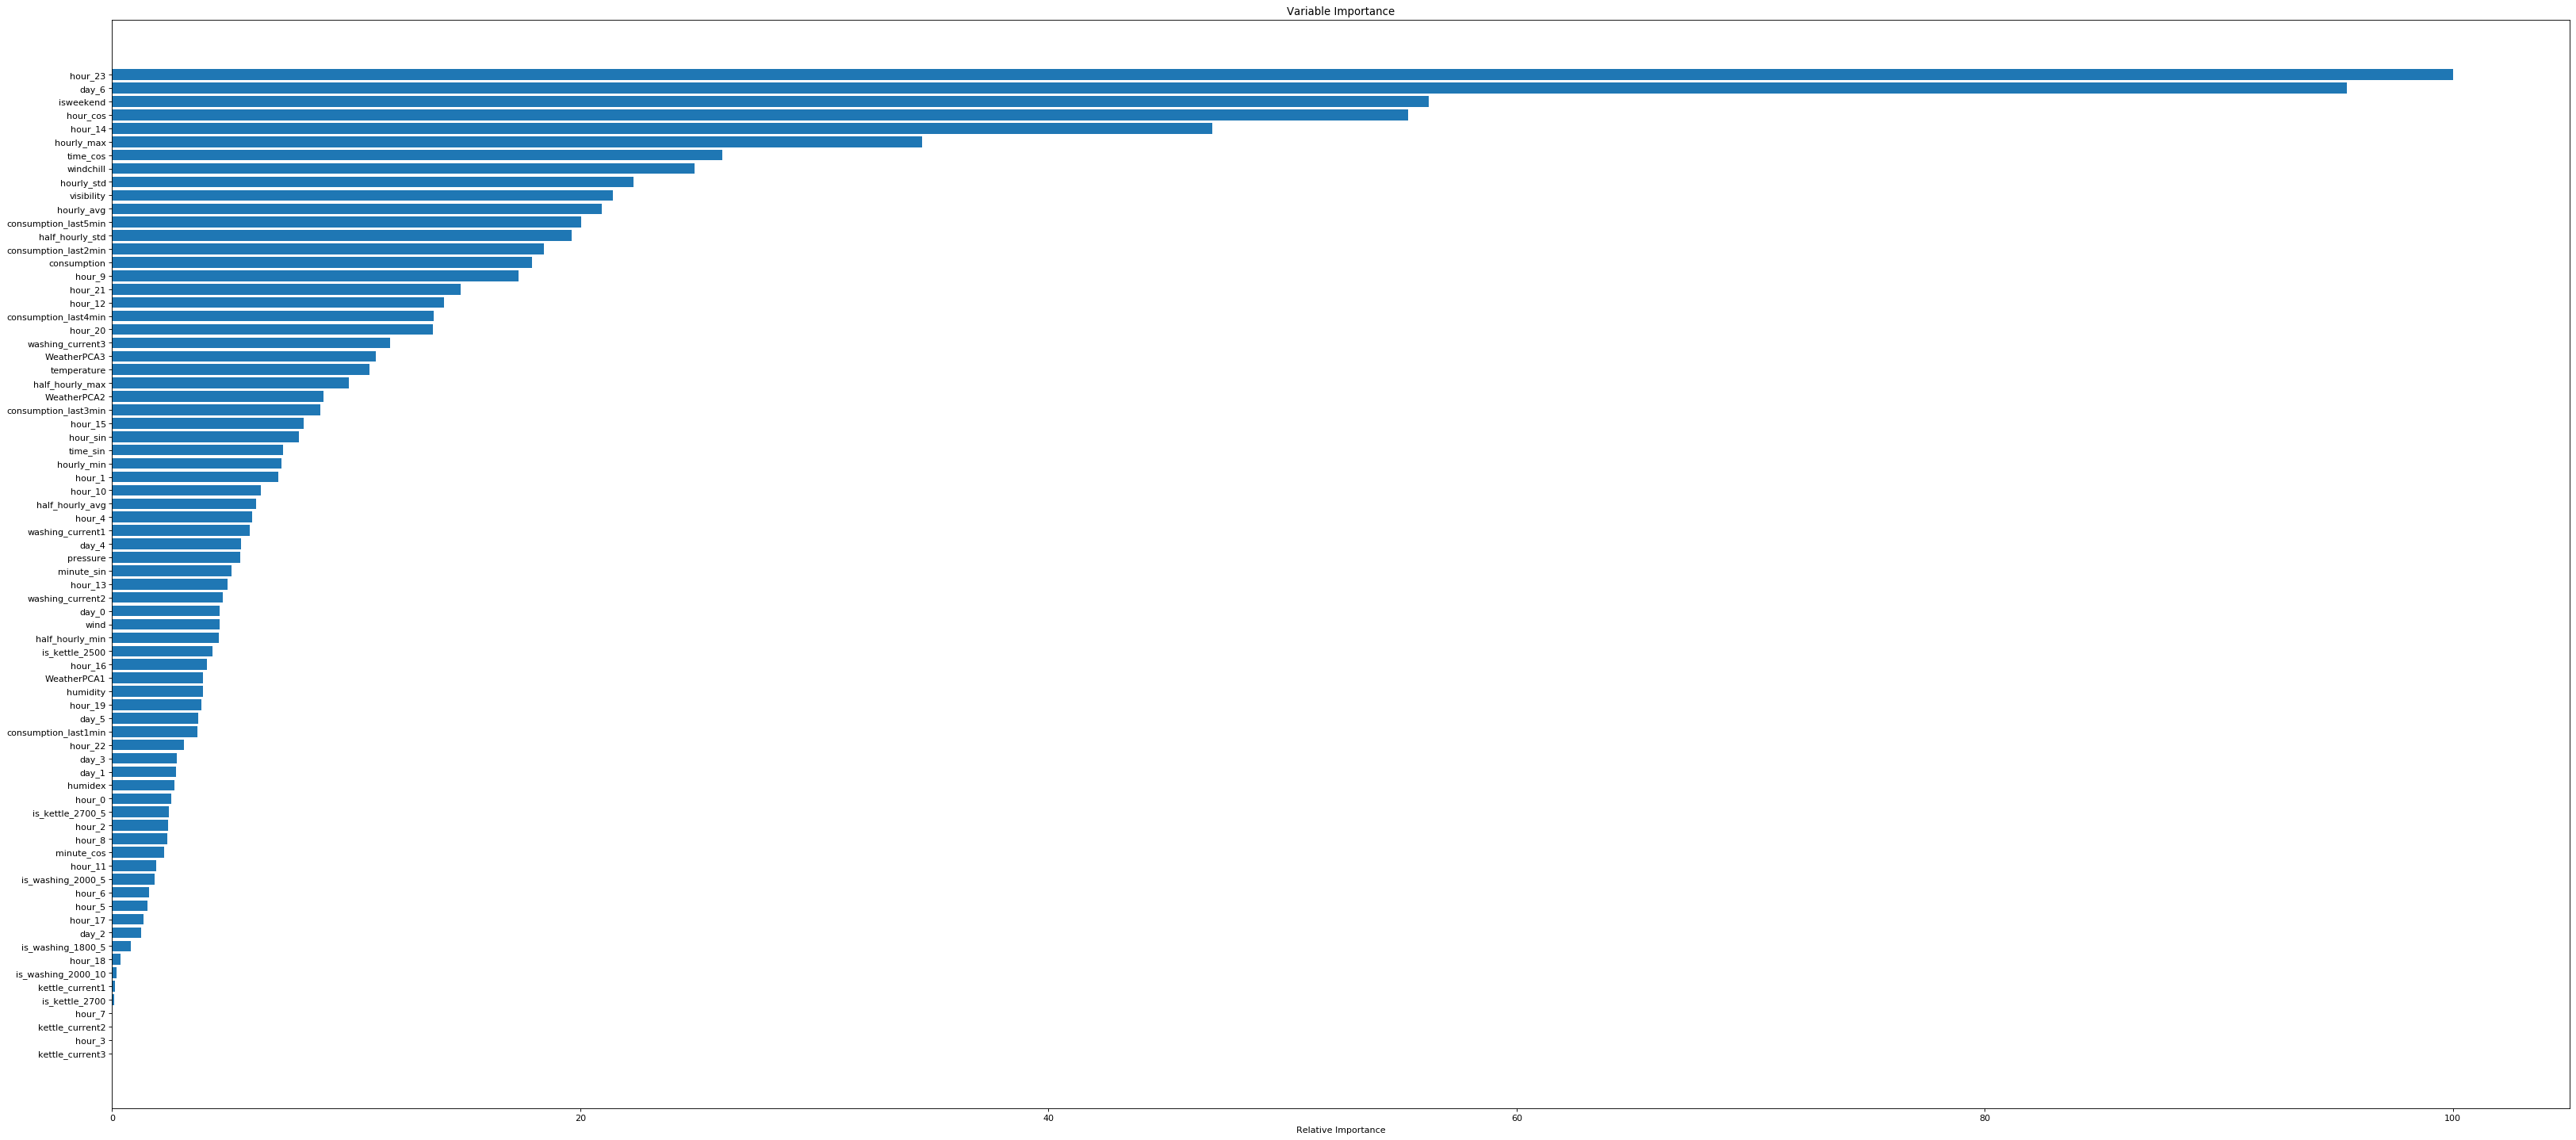

In [242]:
importance(clf1, x_train.columns[1:])

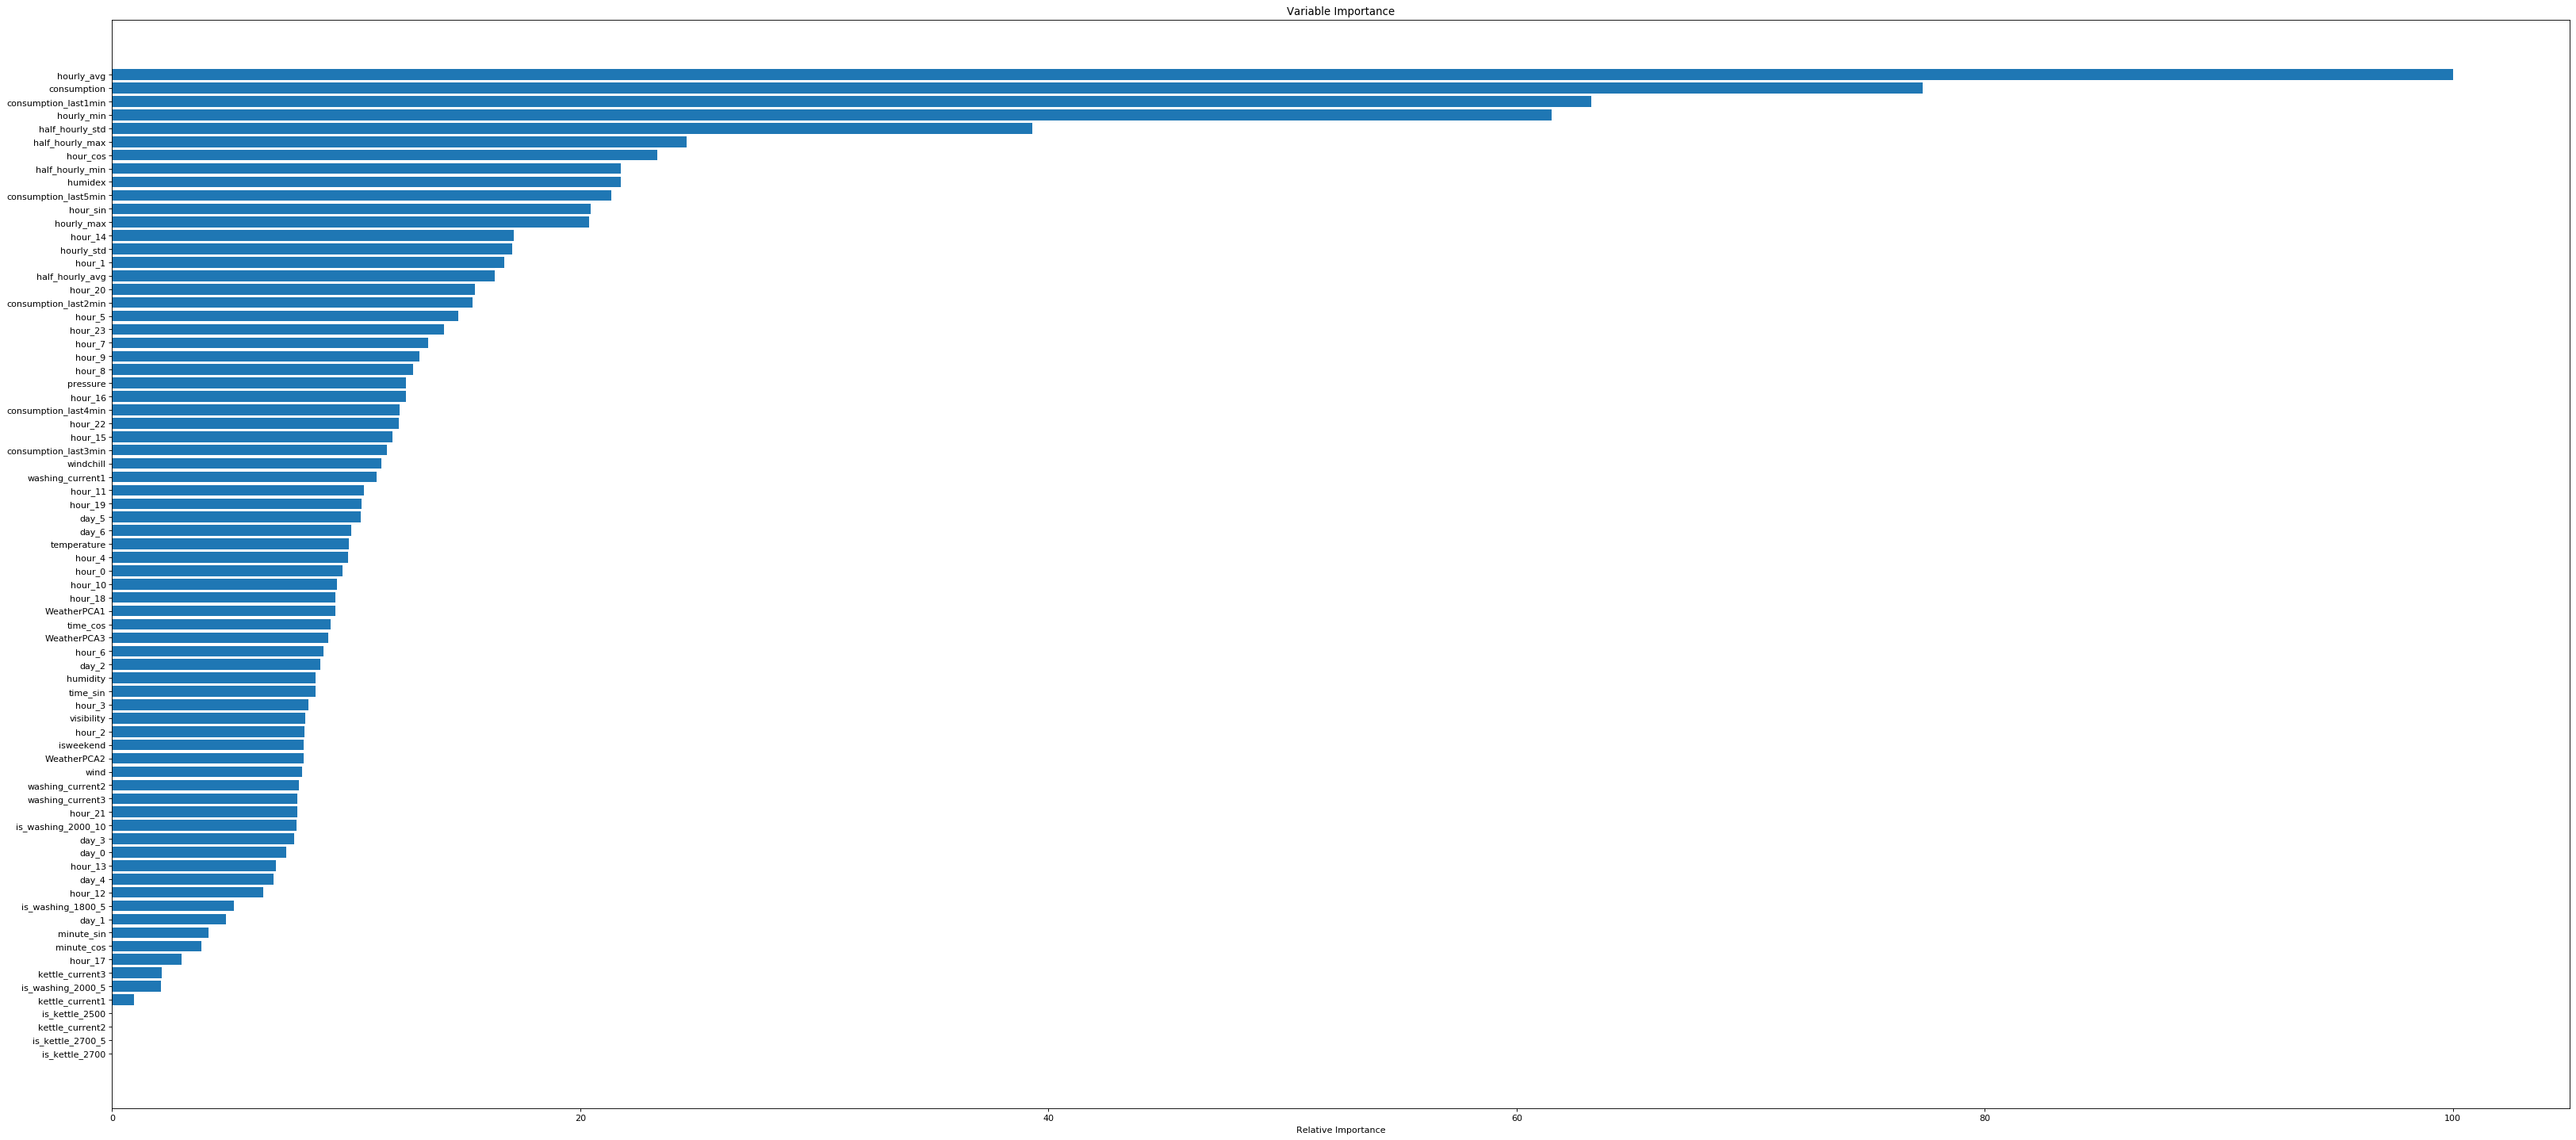

In [243]:
importance(clf2, x_train.columns[1:])

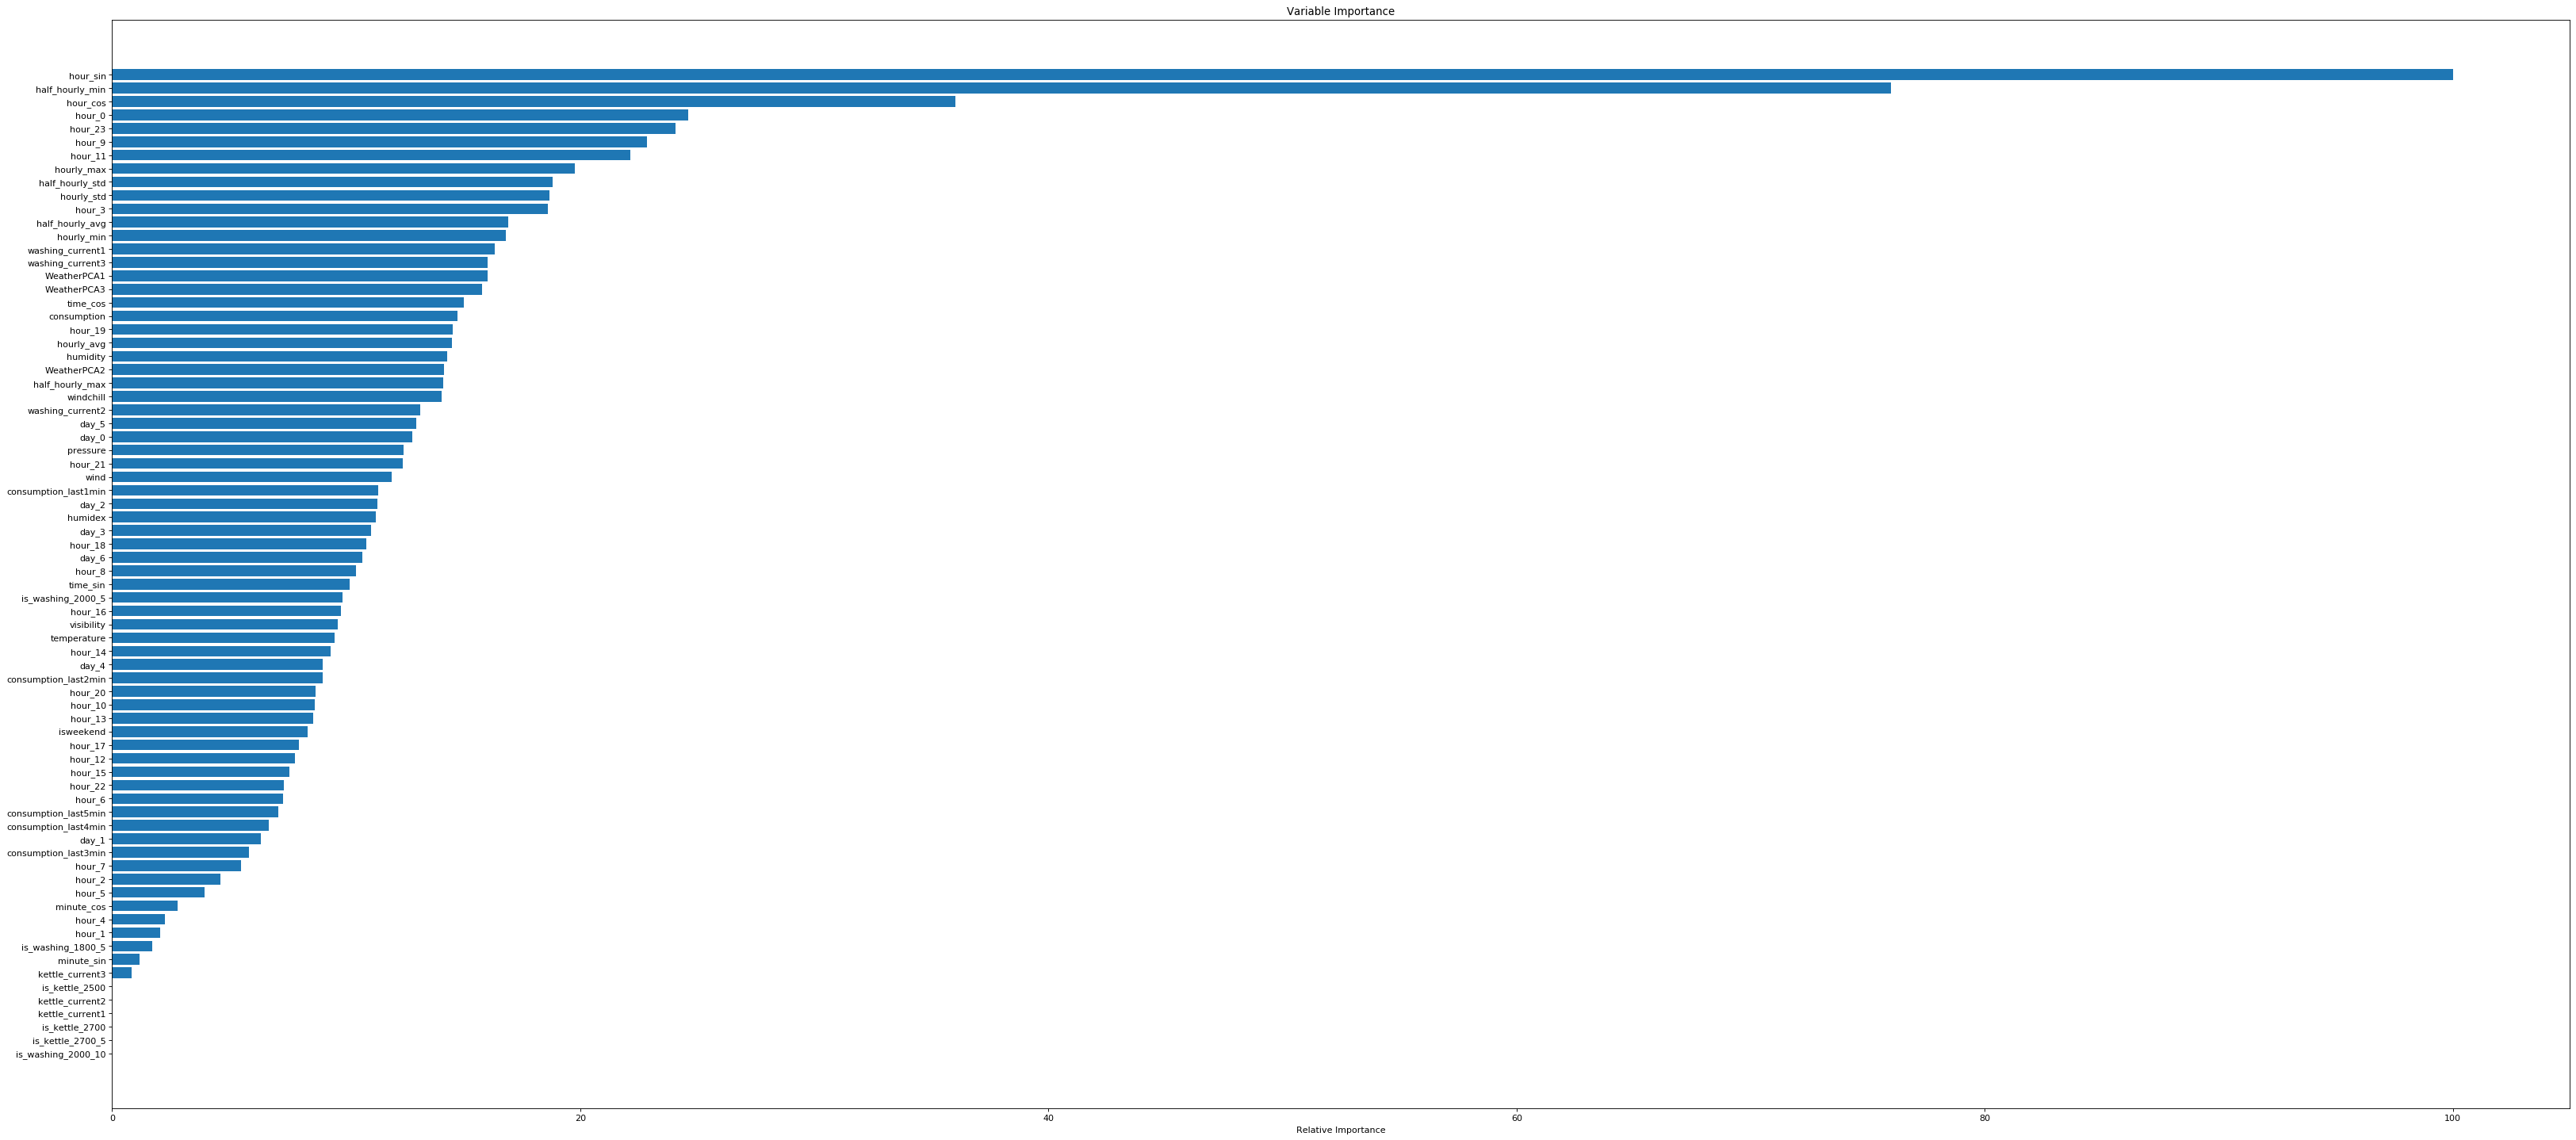

In [244]:
importance(clf3, x_train.columns[1:])

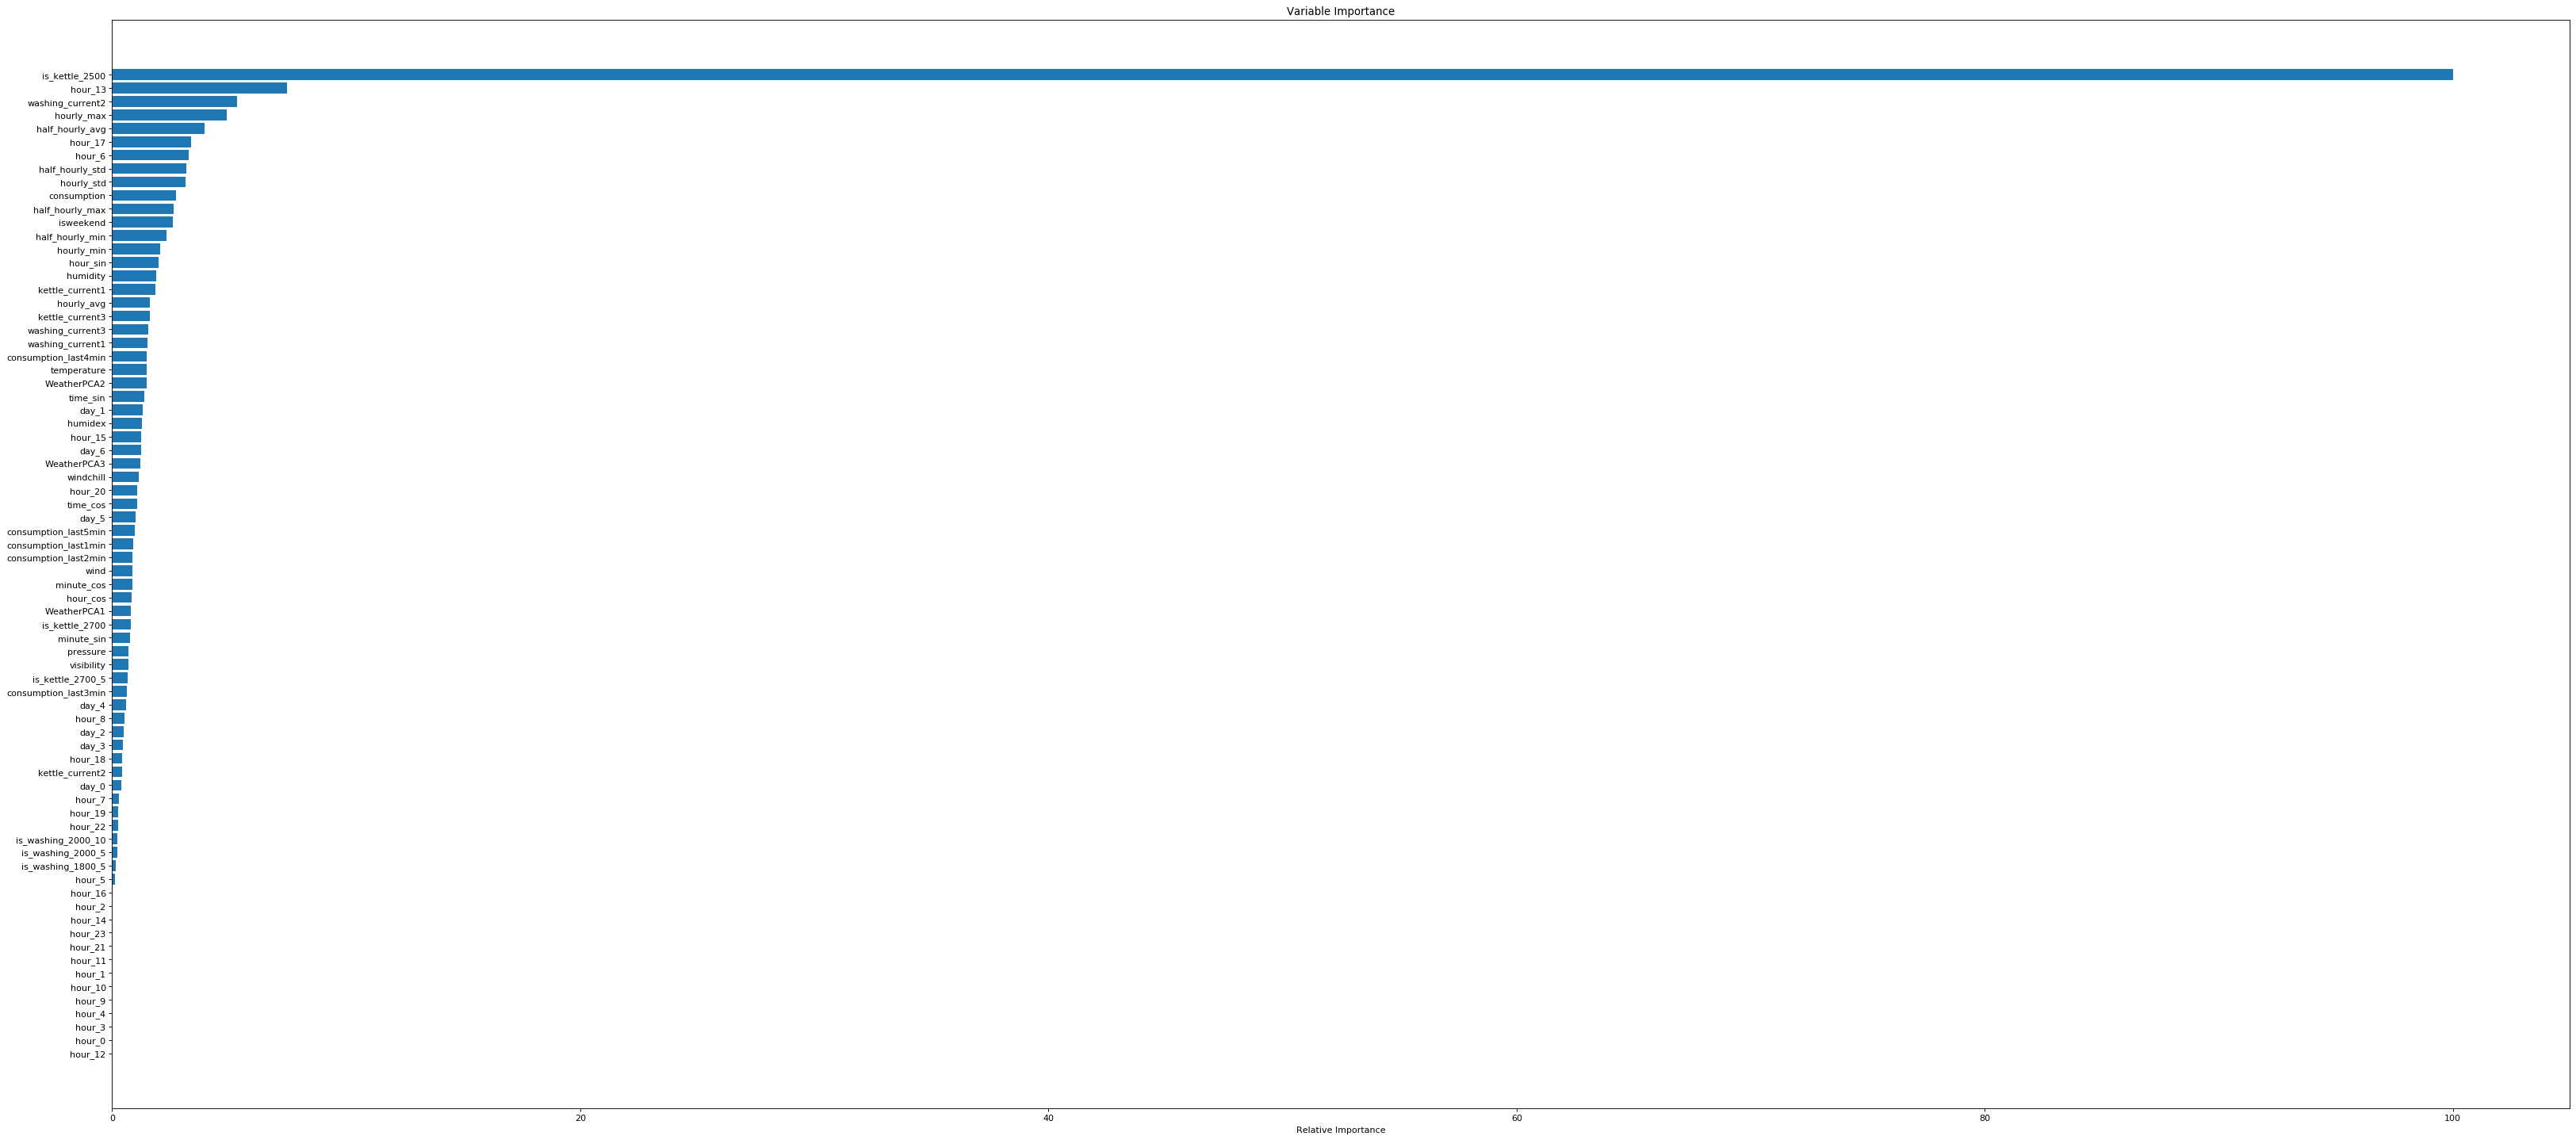

In [245]:
importance(clf4, x_train.columns[1:])

In [251]:
y_pred['washing_machine'] = clf1.predict(x_valid_scaled)
y_pred['fridge_freezer'] = clf2.predict(x_valid_scaled)
y_pred['TV'] = clf3.predict(x_valid_scaled)
y_pred['kettle'] = clf4.predict(x_valid_scaled)

In [252]:
metric_nilm(y_valid, y_pred)

29.865337113372693

In [253]:
X_test.columns

Index(['time_step', 'consumption', 'visibility', 'temperature', 'humidity',
       'humidex', 'windchill', 'wind', 'pressure', 'date', 'hour', 'minute',
       'dayofweek', 'isweekend', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4',
       'day_5', 'day_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'time', 'time_sin',
       'time_cos', 'hour_step', 'hourly_avg', 'hourly_max', 'hourly_min',
       'hourly_std', 'hourly_diff', 'half_hour_step', 'half_hourly_avg',
       'half_hourly_max', 'half_hourly_min', 'half_hourly_std',
       'half_hourly_diff', 'WeatherPCA1', 'WeatherPCA2', 'WeatherPCA3',
       'is_kettle_2500', 'is_kettle_2700', 'is_kettle_2700_5',
       'is_washing_1800_5', 'is_washing_2000

In [257]:
x_test_sub = X_test[['time_step']+X_vars_set]

In [258]:
x_test_scaled = x_test_sub[X_vars_set].values

In [261]:
y_pred = x_test_sub[['time_step']]

In [264]:
y_pred['washing_machine'] = clf1.predict(x_test_scaled)
y_pred['fridge_freezer'] = clf2.predict(x_test_scaled)
y_pred['TV'] = clf3.predict(x_test_scaled)
y_pred['kettle'] = clf4.predict(x_test_scaled)

In [265]:
y_pred.to_csv("y_pred.csv",index=False)

### IV. Combination

**Using different feature sets and models for different appliances**.  
Models to choose from: ELM, XGBoost  
Metric: rmse(col_true, col_pred)  
Goal: to minimize the RMSE for each appliance

```
X_vars = ['consumption', 'visibility', 'temperature', 'humidity','humidex',
                   'windchill', 'wind', 'pressure']
y_vars = ['washing_machine','fridge_freezer','TV','kettle']
X_vars_base = ['consumption']
X_vars_3mins = ['consumption_last1min', 'consumption_last2min', 'consumption_last3min']
X_vars_5mins = ['consumption_last1min', 'consumption_last2min', 'consumption_last3min',
               'consumption_last4min', 'consumption_last5min']
X_vars_day = ['isweekend', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
X_vars_hour1 = ['hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23']
X_vars_hour2 = ['hour_sin', 'hour_cos']
X_vars_minute = ['minute_sin', 'minute_cos']
X_vars_time = ['time_sin', 'time_cos']
X_vars_hourly = ['hourly_avg', 'hourly_std', 'hourly_max', 'hourly_min']
X_vars_half_hourly = ['half_hourly_avg', 'half_hourly_std', 'half_hourly_max', 'half_hourly_min']
X_vars_weather1 = ['visibility', 'temperature', 'humidity',
                   'humidex', 'windchill', 'wind', 'pressure']
X_vars_weather2 = ['WeatherPCA1', 'WeatherPCA2', 'WeatherPCA3']
X_vars_window1 = ['is_kettle_2500', 'is_washing_1800_5', 'kettle_current1', 'washing_current1']
X_vars_window2 = ['is_kettle_2700', 'is_washing_2000_10', 'kettle_current2', 'washing_current2']
X_vars_window3 = ['is_kettle_2700_5', 'is_washing_2000_5', 'kettle_current3', 'washing_current3']
```